Behind the curtain, in this notebook in the first part I implement a Monte Carlo simulation and in the second part a Bayesian analysis where based on prior understanding about how likely we are to have any of many 'true' distributions.  

---


# Too few samples is a problem. And ... too many samples is a problem.  
# aim: How do we figure out just how many we need?

Let's walk through an example.  
_Suppose you recently launched a new energy drink. Your old drink has a 2 star rating based on previous ratings from many tasters._  

_Your team's goal is to determine whether your new drink is, on average, better or worse than your old drink.  
The team asks you: **"...what is the minimum sample size we need to answer this question?"**_

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Q: Is the average rating of our new drink better or worse than the average rating of our old drink?

### What sample size is needed to "precisely" answer this question?

### The average rating of our old drink is 2 stars (on a 1-3 scale)

***

### Without any additional info, let's just pick some reasonable "true" distribution for ratings on our new drink:

#### 1 Star - 15%
#### 2 Star - 65%
#### 3 Star - 20%

### So that the average rating is 1 $\times$ 0.15 + 2 $\times$ 0.65 + 3 $\times$ 0.2 = 2.05

### Now ... how many samples from this distribution would it take to "precisely" say that the new drink is better?

***

In [27]:
RATING_DISTR = np.array([0.15, 0.65, 0.2])

In [16]:
def generate_ratings(rating_distr, n):
    #generates n ratings from the given ratings distribution
    randvals = np.random.random(n).reshape(-1,1)#numpy allow to give one of the shape parameter as -1. It simply means that it is an unknown dimension
                                                #and numpy will figure it out so that the new shape will be compatible with the original shape
    ratings = np.argmax(randvals < rating_distr.cumsum(), axis=1) + 1
    return ratings

In [4]:
ratings = generate_ratings(RATING_DISTR, 100000)
for i in [1,2,3]:
    print('%s Star: %s'%(i, np.mean(ratings==i)))
print('Average Rating: %s'%ratings.mean())

1 Star: 0.14928
2 Star: 0.64988
3 Star: 0.20084
Average Rating: 2.05156


## Suppose our sample size is just 10

In [14]:
def simulate_runs(rating_distr, n):
    #simulate many runs with that sample size
    avg_ratings = []
    
    for _ in range(10000):
        curr_ratings = generate_ratings(rating_distr, n)
        avg_ratings.append(curr_ratings.mean())

    return np.array(avg_ratings)

In [13]:
def plot_distribution(n, avg_ratings, plot=True):
    avg, sd = round(avg_ratings.mean(),3), round(avg_ratings.std(),3)
    if avg > 2:
        pct = np.mean(avg_ratings > 2)
    else:
        pct = np.mean(avg_ratings < 2)
    if plot:
        plt.figure(figsize=(10,4))
        sns.distplot(avg_ratings)
        plt.title('n=%s\nAvg: %s | SD: %s\nPct Distr: %s'%(n, avg, sd, pct), fontsize=20)
        plt.axvline(2, color='r')
        plt.xlabel('Avg Rating', fontsize=16)
        plt.ylabel('Density', fontsize=16)
    
    return pct

0.5033

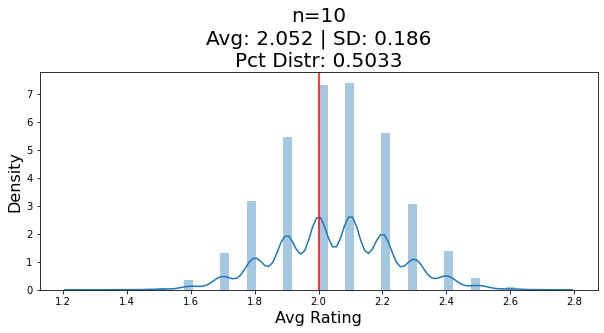

In [7]:
n = 10
avg_ratings = simulate_runs(RATING_DISTR, n)
plot_distribution(n, avg_ratings)

Standard Deviation is large (0.18, we don't like large standard deviations in survey data) implying that we cannot be confident about that average rating. The key number we should pay attention is Percentage Distribution (0.5033): it says that 50% of the time we get that the average rating from those 10 people is actually higher than 2 (i.e. old drink rating). Clearly not a good situation, too much uncertainty. The reason for that is because the sample size is so small; even though the truth is that the new drink is better (2.05>2), our sample size is too small to accurately tells us so.   

So, let's increase the sample size.

## What if our sample size is 100?

0.7732

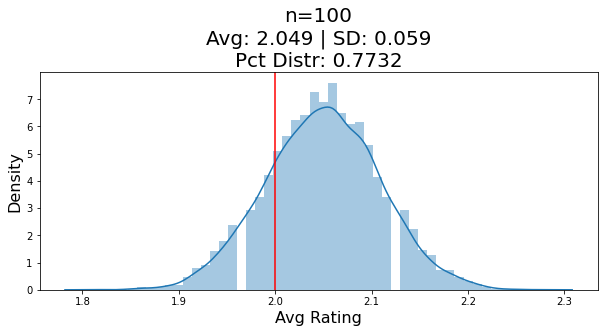

In [28]:
n = 100
avg_ratings = simulate_runs(RATING_DISTR, n)
plot_distribution(n, avg_ratings)

## What if its 1000?

0.9971

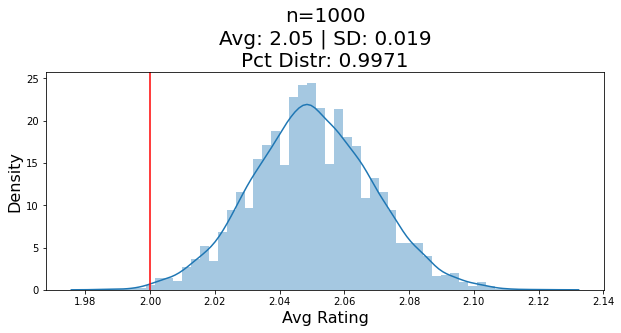

In [9]:
n = 1000
avg_ratings = simulate_runs(RATING_DISTR, n)
plot_distribution(n, avg_ratings)

### But ... all this analysis is dependent on the "true" ratings distribubion above. What if instead it was:

#### 1 Star - 5%
#### 2 Star - 50%
#### 3 Star - 45%

### So that the average rating is 1 $\times$ 0.05 + 2 $\times$ 0.5 + 3 $\times$ 0.45 = 2.4

### Now ... how many samples from this distribution would it take to "precisely" say that the new drink is better?

***

In [10]:
RATING_DISTR = np.array([0.05, 0.5, 0.45])

0.9711

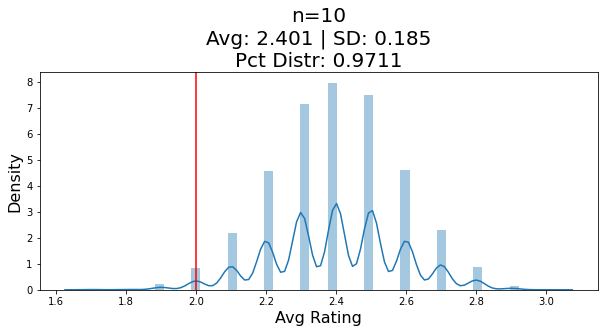

In [11]:
n = 10
avg_ratings = simulate_runs(RATING_DISTR, n)
plot_distribution(n, avg_ratings)

# Now, we can try out a bunch of different "true" distributions and see how the required sample size changes with each one!

In [17]:
#get many possible rating distributions
rating_distributions = []
p1_vals = np.arange(0,1.1,.1)
for p1 in p1_vals:
    for p2 in np.arange(0, 1-p1, 0.1):
        rating_distributions.append(np.array([p1,p2,1-p1-p2]))

In [18]:
#this list will store the required sample size for each rating distribution
required_sample_sizes = []
for rating_distribution in rating_distributions:
    req_samp_size = -1
    for n in [5, 10, 25, 50, 100, 250, 500, 1000]:
        avg_ratings = simulate_runs(rating_distribution, n)
        pct = plot_distribution(n, avg_ratings, plot=False)
        if pct > 0.95: #set criteria for when to stop checking sample sizes
            req_samp_size = n
            break
    required_sample_sizes.append(req_samp_size)

In [19]:
p1_vals = np.array([item[0] for item in rating_distributions])
p2_vals = np.array([item[1] for item in rating_distributions])

(-0.05, 1.0)

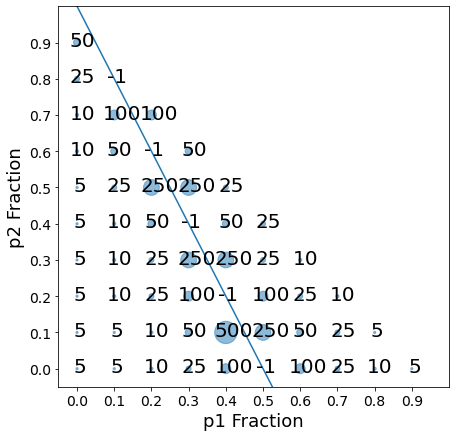

In [23]:
plt.figure(figsize=(7,7))
plt.scatter(p1_vals, p2_vals, s=required_sample_sizes, alpha=0.5)
plt.xticks(np.arange(0,1,.1), fontsize=14)
plt.yticks(np.arange(0,1,.1), fontsize=14)
plt.xlabel('p1 Fraction', fontsize=18)
plt.ylabel('p2 Fraction', fontsize=18)
for i,r in enumerate(required_sample_sizes):
    plt.annotate(r, (p1_vals[i]-.01*len(str(r)), p2_vals[i]-.01), fontsize=20, fontweight=2)
plt.plot(p1_vals, -2*p1_vals+1)
plt.xlim(-.05,1)
plt.ylim(-.05,1)

**Interpretation**   
Let's understand what the diagram above is telling us.    
x-axis: p1 Fraction is the proportion of people that think the drink is worth 1 star  
y-axis: p2 Fraction is the proportion of people that think the drink is worth 2 stars   
Obviously, p3 = 1- p1 - p2   
For example, the coordinate (0.2;0.3) should be interpreted as "if 20% of people think the drink deserves 1 star and 30% of people think the drink deserves 2 stars (hence, 60% think it deserves 3 stars), then we need a sample size of 25 for confidently answer whether the new drink is than the old one".   
To further interpret the diagram, the blu line indicates all the possible (p1,p2,p3) combinations where the average rating is exactly 2. In this case '-1' indicates that we can never have enough samples to say if the new drink is better or worse.   
The closer you are to the blue line, namely the true average is close to the old average of 2, the more sample size is needed to answer the initial question. Conversely, the further away you get from the blue line, the less sample is needed

_Now suppose you back to your team with the diagram just obtained. After a brainstorming to decide what the most probable 'true' distribution for the new drink is, you narrow p1 range between 0 and 0.2 (the green region below)_.  

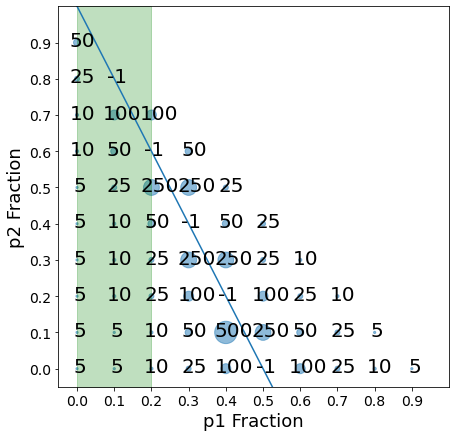

In [24]:
plt.figure(figsize=(7,7))
plt.scatter(p1_vals, p2_vals, s=required_sample_sizes, alpha=0.5)
plt.xticks(np.arange(0,1,.1), fontsize=14)
plt.yticks(np.arange(0,1,.1), fontsize=14)
plt.xlabel('p1 Fraction', fontsize=18)
plt.ylabel('p2 Fraction', fontsize=18)
for i,r in enumerate(required_sample_sizes):
    plt.annotate(r, (p1_vals[i]-.01*len(str(r)), p2_vals[i]-.01), fontsize=20, fontweight=2)
plt.plot(p1_vals, -2*p1_vals+1)
plt.xlim(-.05,1)
plt.ylim(-.05,1)
plt.fill_betweenx([-.1,1], 0, 0.2, color='green', alpha=0.25)

If we look only within the green area, the biggest sample size required is 100, so precautionally based on this analysis you might suggest to pick a sample size of 100 in order to make a reliable assessment whether the new drink in better or worse than the old drink.